In [ ]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 44.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Explore Dataset

In [ ]:
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/content/drive/MyDrive/PCB_DATASET/rotation
/content/drive/MyDrive/PCB_DATASET/images
/content/drive/MyDrive/PCB_DATASET/Annotations
/content/drive/MyDrive/PCB_DATASET/PCB_USED
/content/drive/MyDrive/PCB_DATASET/images_resized
/content/drive/MyDrive/PCB_DATASET/output
/content/drive/MyDrive/PCB_DATASET/rotation/Spurious_copper_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Open_circuit_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Missing_hole_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Short_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Spur_rotation
/content/drive/MyDrive/PCB_DATASET/rotation/Mouse_bite_rotation
/content/drive/MyDrive/PCB_DATASET/images/Spurious_copper
/content/drive/MyDrive/PCB_DATASET/images/Spur
/content/drive/MyDrive/PCB_DATASET/images/Short
/content/drive/MyDrive/PCB_DATASET/images/Missing_hole
/content/drive/MyDrive/PCB_DATASET/images/Mouse_bite
/content/drive/MyDrive/PCB_DATASET/images/Open_circuit
/content/drive/MyDrive/PCB_DATASE

In [ ]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [ ]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


##Create annotaton dataset

In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return data

In [ ]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [ ]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  01_spur_02.jpg   3034    1586  spur   766  1156   804  1199
1  01_spur_02.jpg   3034    1586  spur   720  1224   758  1259
2  01_spur_02.jpg   3034    1586  spur   821  1337   862  1377
3  01_spur_04.jpg   3034    1586  spur  2708   937  2751   973
4  01_spur_04.jpg   3034    1586  spur  2153  1156  2190  1189

##Visualization

In [ ]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [ ]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

         # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image

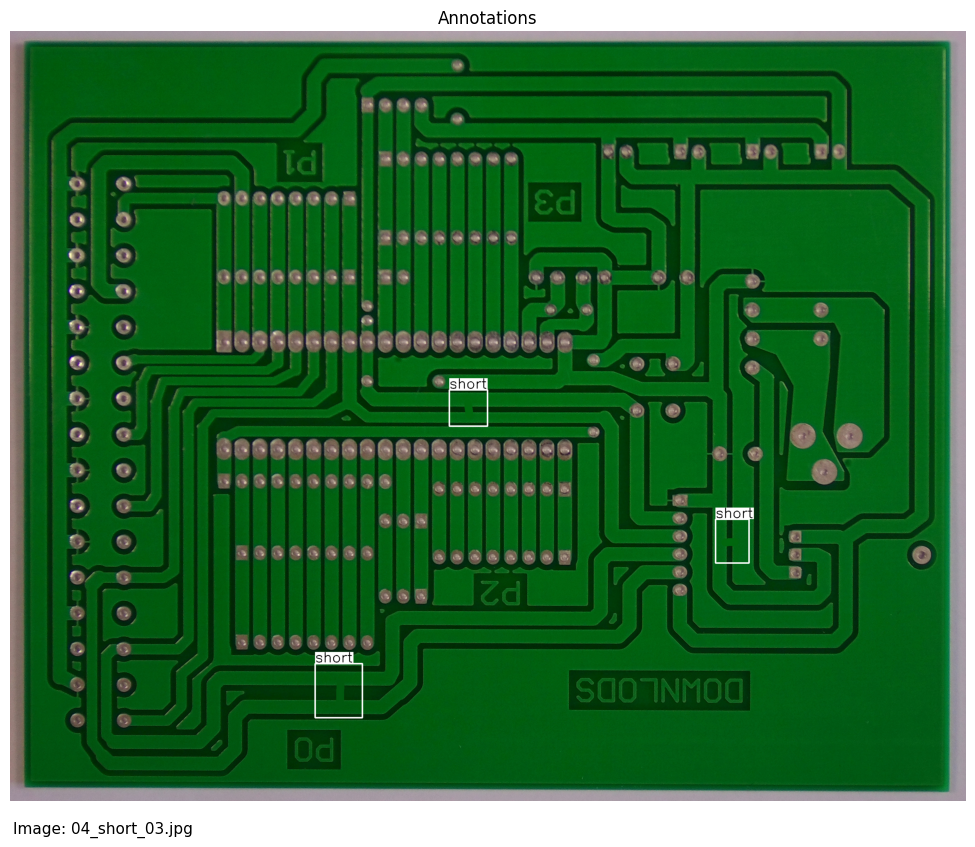

array([[[159, 144, 165],
        [153, 139, 157],
        [155, 142, 158],
        ...,
        [170, 157, 173],
        [168, 155, 171],
        [168, 155, 171]],

       [[154, 139, 160],
        [153, 139, 157],
        [152, 139, 155],
        ...,
        [168, 155, 171],
        [167, 154, 170],
        [169, 156, 172]],

       [[156, 141, 162],
        [159, 145, 163],
        [155, 142, 158],
        ...,
        [166, 153, 169],
        [167, 154, 170],
        [169, 156, 172]],

       ...,

       [[159, 146, 162],
        [159, 146, 162],
        [159, 146, 162],
        ...,
        [161, 151, 164],
        [162, 152, 165],
        [162, 152, 164]],

       [[160, 147, 163],
        [159, 146, 162],
        [158, 145, 161],
        ...,
        [161, 151, 164],
        [161, 151, 164],
        [159, 151, 162]],

       [[163, 150, 166],
        [161, 148, 164],
        [159, 146, 162],
        ...,
        [161, 151, 164],
        [160, 150, 163],
        [158, 150, 161]]

In [ ]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True)

##Dataset preprocessing

In [ ]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [ ]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })
    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

filename  width  height class  xmin  ymin  xmax  ymax
0  01_spur_02.jpg    640     640  spur   161   466   169   483
1  01_spur_02.jpg    640     640  spur   151   493   159   508
2  01_spur_02.jpg    640     640  spur   173   539   181   555
3  01_spur_04.jpg    640     640  spur   571   378   580   392
4  01_spur_04.jpg    640     640  spur   454   466   461   479

##Split dataset

In [ ]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)

In [ ]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

##K-Fold Cross Validation

In [ ]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [ ]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [ ]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [ ]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

<ipython-input-36-635b1554578e>:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


0    1    2    3    4    5
01_missing_hole_01  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_03  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_04  3.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_05  4.0  0.0  0.0  0.0  0.0  0.0
01_missing_hole_07  3.0  0.0  0.0  0.0  0.0  0.0

In [ ]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [ ]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

<ipython-input-38-68702af6ce23>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
<ipython-input-38-68702af6ce23>:6: FutureWarning: ChainedAssignmentError: behaviour will cha

In [ ]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

0         1         2         3         4         5
split_1  0.407855  0.398176  0.439252  0.448485   0.57931   0.71831
split_2  0.676259  0.575342  0.604167  0.393586  0.511551  0.394286
split_3  0.442724  0.538462  0.466667  0.689046  0.417957  0.426901

In [ ]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [ ]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [ ]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

##Model Training

In [ ]:
model = YOLO('yolov8s.pt')
results = {}
batch = 16
project = 'pcb'
epochs = 100
imgsz=640
save_period=1
verbose=True
mixup = 0.3

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(data=dataset_yaml,
                epochs=epochs,
                batch=batch,
                lr0=0.001,
                lrf=0.0001,
                imgsz=imgsz,
                save_period=save_period,
                verbose=verbose,
                project=project,
                mixup=mixup)
    results[k] = model.metrics  # save output metrics for further analysis

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/split_1_dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/train/labels.cache... 438 images, 0 backgrounds, 0 corrupt: 100%|██████████| 438/438 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_1/val/labels.cache... 220 images, 0 backgrounds, 0 corrupt: 100%|██████████| 220/220 [00:00<?, ?it/s]


Plotting labels to pcb/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.18G      3.947      18.94      2.046         59        640: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.04s/it]

                   all        220        927   0.000223     0.0617   0.000155   8.53e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.39G      3.147       4.65      1.363         48        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.20it/s]

                   all        220        927       0.12      0.166     0.0878     0.0354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.36G      2.683      3.262      1.232         61        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        220        927      0.065     0.0209     0.0359     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.38G       2.59      2.845      1.192         52        640: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

                   all        220        927       0.47      0.407      0.365      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.35G      2.413      2.343      1.134         48        640: 100%|██████████| 28/28 [00:15<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        220        927      0.701       0.48      0.523      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.35G       2.47      2.388      1.137         18        640: 100%|██████████| 28/28 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]

                   all        220        927       0.66      0.574      0.618      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.38G       2.37      2.226      1.119         40        640: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.29it/s]

                   all        220        927      0.752      0.584      0.678      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.38G      2.311      2.071      1.098         28        640: 100%|██████████| 28/28 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.18it/s]

                   all        220        927      0.703      0.604      0.677      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.37G      2.239      1.893      1.096         45        640: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        220        927      0.795      0.641      0.697      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.37G      2.196      1.779      1.076         59        640: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        220        927      0.806      0.661      0.746      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.31G      2.202       1.77      1.057         53        640: 100%|██████████| 28/28 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        220        927      0.781      0.693      0.768      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.32G      2.155      1.699       1.05         53        640: 100%|██████████| 28/28 [00:13<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        220        927      0.786      0.673      0.744      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.37G      2.138      1.687      1.054         29        640: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]

                   all        220        927      0.816      0.734      0.803      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.36G      2.124      1.606      1.043         29        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]

                   all        220        927      0.879      0.752      0.796      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.34G      2.102      1.586      1.047         35        640: 100%|██████████| 28/28 [00:12<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]

                   all        220        927       0.82      0.724      0.771      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.33G      2.055      1.589      1.031         59        640: 100%|██████████| 28/28 [00:12<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        220        927      0.919      0.692      0.805      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.34G      2.068      1.521      1.051         44        640: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        220        927      0.914       0.74      0.815      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.35G       2.07      1.569      1.035         29        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

                   all        220        927      0.911      0.752      0.822      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.35G          2      1.461      1.022         47        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        220        927        0.9      0.772      0.825      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.36G      2.046      1.464       1.03         34        640: 100%|██████████| 28/28 [00:12<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

                   all        220        927      0.865      0.739      0.809      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.35G      2.084      1.547      1.043         42        640: 100%|██████████| 28/28 [00:13<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        220        927      0.882      0.769      0.834      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.35G      2.009      1.419      1.031         46        640: 100%|██████████| 28/28 [00:12<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        220        927      0.943      0.773       0.86      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.35G      1.971      1.359      1.003         23        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        220        927      0.954      0.742      0.834      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.31G      2.023      1.449       1.03         45        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

                   all        220        927      0.908      0.773       0.85      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.29G      1.986      1.422      1.001         29        640: 100%|██████████| 28/28 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        220        927      0.877      0.804      0.854      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.37G      1.936      1.343      1.008         29        640: 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        220        927      0.913      0.805      0.849      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.33G      1.972      1.404      1.003         30        640: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

                   all        220        927      0.908      0.786      0.851      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.35G      1.952       1.35     0.9942         35        640: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.67it/s]

                   all        220        927      0.908      0.793      0.842       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.36G      1.923      1.325     0.9957         34        640: 100%|██████████| 28/28 [00:12<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        220        927      0.948      0.791       0.87       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.29G      1.883      1.281     0.9884         25        640: 100%|██████████| 28/28 [00:11<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

                   all        220        927       0.92       0.82       0.88      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.36G      1.969      1.361      1.014         63        640: 100%|██████████| 28/28 [00:11<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]

                   all        220        927      0.948      0.829      0.879      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.32G      1.849      1.239     0.9916         20        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.47it/s]

                   all        220        927      0.919      0.835      0.877      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.36G       1.93      1.367      1.001         45        640: 100%|██████████| 28/28 [00:12<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

                   all        220        927      0.902      0.829      0.872      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.29G      1.838       1.25      0.987         46        640: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]

                   all        220        927       0.92      0.804      0.872        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.36G      1.877      1.293     0.9833         53        640: 100%|██████████| 28/28 [00:12<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        220        927      0.932      0.825      0.879       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.32G      1.842      1.283     0.9816         34        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        220        927       0.92      0.811      0.883      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.37G      1.899      1.322     0.9897         53        640: 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]

                   all        220        927      0.927      0.815      0.882      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.36G      1.825      1.201     0.9775         47        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.44it/s]

                   all        220        927      0.919      0.844      0.887      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.37G      1.883      1.213     0.9878         42        640: 100%|██████████| 28/28 [00:12<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        220        927      0.902      0.834       0.88      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.35G      1.855      1.253      0.974         39        640: 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        220        927      0.925      0.828       0.89      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.37G      1.872      1.274      0.987         26        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        220        927      0.934      0.835       0.89      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.34G      1.838       1.18     0.9674         42        640: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        220        927       0.94      0.849      0.897       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.34G      1.833      1.174     0.9894         40        640: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.82it/s]

                   all        220        927      0.932       0.83      0.886      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.35G      1.796      1.183     0.9655         33        640: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        220        927      0.943      0.822      0.893      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.36G      1.836      1.207     0.9661         32        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        220        927      0.918      0.843      0.892      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.33G       1.83        1.2     0.9748         33        640: 100%|██████████| 28/28 [00:14<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]

                   all        220        927      0.905      0.834      0.888       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.34G      1.843      1.222     0.9807         33        640: 100%|██████████| 28/28 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        220        927       0.91       0.85      0.898       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.32G      1.869      1.244      0.982         57        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        220        927      0.949       0.83      0.891      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.33G        1.8      1.225     0.9691         33        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        220        927      0.924      0.858        0.9      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.49G      1.793      1.186     0.9576         33        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        220        927      0.937      0.825      0.894      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.36G      1.791      1.164     0.9602         30        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        220        927      0.944      0.833      0.898      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.28G       1.79      1.179     0.9689         41        640: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        220        927      0.902       0.85      0.897       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.45G      1.764      1.145     0.9595         32        640: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        220        927      0.928      0.825      0.893      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.33G      1.767       1.14     0.9562         56        640: 100%|██████████| 28/28 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        220        927      0.925      0.859      0.902      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.33G       1.74      1.112     0.9562         52        640: 100%|██████████| 28/28 [00:15<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        220        927       0.93      0.858      0.905      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.35G       1.74      1.137     0.9522         38        640: 100%|██████████| 28/28 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        220        927      0.939      0.855      0.914      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.34G      1.723      1.104     0.9527         40        640: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        220        927      0.935      0.844      0.897      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.29G      1.704       1.12     0.9534         45        640: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

                   all        220        927      0.933      0.868      0.912      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.29G      1.775       1.15     0.9536         35        640: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        220        927      0.925      0.846      0.889      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.35G      1.743      1.115     0.9498         49        640: 100%|██████████| 28/28 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        220        927      0.918       0.86      0.903      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.35G      1.698      1.052     0.9507         25        640: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        220        927      0.924      0.861      0.904      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.35G      1.727      1.088     0.9585         70        640: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        220        927      0.957      0.859      0.917      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.36G      1.703       1.08      0.944         31        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        220        927       0.96       0.84      0.912      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       4.3G      1.712      1.038      0.947         29        640: 100%|██████████| 28/28 [00:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        220        927      0.936       0.87      0.915      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.51G      1.706      1.078     0.9522         49        640: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        220        927      0.933      0.881      0.913      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.28G      1.701      1.063     0.9438         42        640: 100%|██████████| 28/28 [00:14<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        220        927      0.942      0.872      0.918      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.29G      1.699      1.071     0.9509         39        640: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        220        927      0.921       0.86      0.903      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.37G      1.698      1.099     0.9445         76        640: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        220        927       0.95      0.877      0.918       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.32G      1.665      1.046     0.9402         56        640: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        220        927      0.952      0.856      0.916      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.36G      1.648      1.021     0.9325         24        640: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        220        927      0.954      0.859      0.917      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.37G      1.632       1.02     0.9438         52        640: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        220        927       0.95       0.87      0.916      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.33G      1.649      1.003     0.9316         43        640: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        220        927      0.945      0.866      0.915      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.33G      1.662      1.018     0.9386         38        640: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        220        927      0.947      0.857      0.915      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.32G      1.629      1.012     0.9282         50        640: 100%|██████████| 28/28 [00:14<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        220        927      0.918       0.88      0.907      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.37G      1.656       1.03     0.9361         39        640: 100%|██████████| 28/28 [00:14<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        220        927      0.949      0.885       0.92      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.33G      1.622     0.9678     0.9274         35        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        220        927      0.943      0.884      0.922      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.34G      1.621     0.9948     0.9269         58        640: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        220        927      0.947      0.881      0.924       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.31G      1.628      1.006     0.9355         61        640: 100%|██████████| 28/28 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        220        927      0.948      0.873      0.916      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.37G       1.62      1.002     0.9201         43        640: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        220        927      0.959      0.865       0.92      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.32G      1.593     0.9859     0.9241         23        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.15it/s]

                   all        220        927      0.935      0.871       0.92      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.45G      1.602     0.9653      0.927         27        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.90it/s]

                   all        220        927      0.944      0.885      0.918      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.33G      1.558      0.946     0.9226         59        640: 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        220        927      0.947      0.875      0.921      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.28G       1.58     0.9769     0.9201         21        640: 100%|██████████| 28/28 [00:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        220        927      0.945      0.873      0.918      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.45G      1.534     0.9078     0.9157         31        640: 100%|██████████| 28/28 [00:14<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        220        927      0.949      0.879      0.915      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.35G       1.59     0.9591     0.9246         24        640: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        220        927      0.952      0.876      0.921      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.53G      1.603     0.9768     0.9261         36        640: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

                   all        220        927      0.956       0.88      0.923      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.33G      1.534     0.9002     0.9057         39        640: 100%|██████████| 28/28 [00:13<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

                   all        220        927      0.947      0.883      0.923       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.31G      1.575     0.9483     0.9236         49        640: 100%|██████████| 28/28 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        220        927      0.947      0.881      0.923      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.43G        1.6     0.9702     0.9266         36        640: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        220        927      0.956      0.878      0.925       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.34G      1.515     0.8974     0.9138         37        640: 100%|██████████| 28/28 [00:14<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        220        927      0.955      0.877      0.918      0.455


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100       4.3G      1.347      0.681      0.891         28        640: 100%|██████████| 28/28 [00:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

                   all        220        927      0.947      0.879      0.925       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.33G      1.321     0.6421     0.8908         22        640: 100%|██████████| 28/28 [00:13<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        220        927      0.947      0.876       0.92      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.31G       1.31     0.6372     0.8905         26        640: 100%|██████████| 28/28 [00:13<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        220        927      0.955      0.875      0.923      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.32G      1.277     0.6328     0.8879         25        640: 100%|██████████| 28/28 [00:13<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        220        927      0.947      0.879      0.923      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.31G      1.282     0.6219      0.893         22        640: 100%|██████████| 28/28 [00:11<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]

                   all        220        927      0.964      0.866      0.924      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.33G      1.296     0.6227     0.8842         23        640: 100%|██████████| 28/28 [00:09<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        220        927      0.949      0.871      0.916      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.31G      1.291     0.6122     0.8873         25        640: 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]

                   all        220        927      0.954      0.873      0.917      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.33G      1.262     0.6104     0.8839         23        640: 100%|██████████| 28/28 [00:09<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        220        927      0.952       0.88      0.922      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.31G      1.254     0.6063      0.877         24        640: 100%|██████████| 28/28 [00:10<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        220        927      0.956      0.882      0.924      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.33G      1.282      0.618     0.8838         23        640: 100%|██████████| 28/28 [00:11<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.32it/s]

                   all        220        927      0.956       0.88      0.922      0.458



100 epochs completed in 0.552 hours.
Optimizer stripped from pcb/train2/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train2/weights/best.pt, 22.5MB

Validating pcb/train2/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]


                   all        220        927      0.951      0.875      0.921      0.468
          missing_hole         31        135      0.996      0.993      0.995      0.585
            mouse_bite         35        131       0.88      0.771      0.824      0.397
          open_circuit         32        141      0.952      0.846      0.902      0.433
                 short         36        148      0.972      0.941      0.972      0.503
                  spur         38        168      0.972      0.817      0.879      0.405
       spurious_copper         48        204      0.936      0.882      0.954      0.484
Speed: 0.4ms preprocess, 5.2ms inference, 0.0ms loss, 7.7ms postprocess per image
Results saved to pcb/train2
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/split_2_dataset.yaml, epochs=100, time=None, patience=10

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels... 439 images, 0 backgrounds, 0 corrupt: 100%|██████████| 439/439 [00:06<00:00, 71.18it/s]


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:06<00:00, 36.13it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_2/val/labels.cache
Plotting labels to pcb/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train22
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.72G      1.754       1.08     0.9569         49        640: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        219        958      0.973      0.949      0.972      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.43G      1.766       1.11     0.9626         50        640: 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        958      0.963      0.946      0.965      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       4.4G       1.82      1.195     0.9763         38        640: 100%|██████████| 28/28 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        219        958      0.956      0.937       0.97      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.24G      1.818      1.198     0.9724         51        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        219        958      0.946      0.919      0.951      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.23G      1.828       1.17     0.9668         39        640: 100%|██████████| 28/28 [00:11<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        219        958      0.937      0.911      0.942      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.24G      1.826      1.199     0.9563         45        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

                   all        219        958       0.94      0.913      0.949       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.24G      1.871      1.274     0.9802         68        640: 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

                   all        219        958      0.948      0.909      0.951      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.21G      1.834      1.244     0.9682         49        640: 100%|██████████| 28/28 [00:15<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        219        958      0.926      0.908      0.952      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.21G      1.844      1.201     0.9694         63        640: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]

                   all        219        958      0.931      0.926      0.955      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.22G      1.825      1.188     0.9771         45        640: 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        219        958      0.945      0.892      0.945      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.21G       1.83      1.231     0.9619         29        640: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        219        958      0.948      0.913      0.955      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.16G        1.8      1.172     0.9578         35        640: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.09it/s]

                   all        219        958      0.955      0.922      0.955      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.16G      1.874      1.252     0.9876         24        640: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        219        958      0.953      0.891      0.945      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.21G       1.83      1.202     0.9756         57        640: 100%|██████████| 28/28 [00:15<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        219        958      0.934      0.925      0.951      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.21G      1.807      1.172     0.9617         25        640: 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        219        958       0.95      0.929      0.954      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.24G      1.819      1.206     0.9732         50        640: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]

                   all        219        958      0.951      0.912      0.944      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.24G      1.763      1.136     0.9559         60        640: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        219        958      0.955      0.916      0.955      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.21G      1.832      1.239     0.9681         53        640: 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        219        958      0.962      0.895      0.952      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.21G      1.803      1.177     0.9607         53        640: 100%|██████████| 28/28 [00:13<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        958      0.953      0.927      0.962      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.23G      1.817      1.177     0.9658         42        640: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        219        958      0.937      0.917      0.946      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.24G      1.801      1.148     0.9562         50        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]

                   all        219        958      0.967      0.919      0.959      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.24G      1.722      1.119     0.9437         72        640: 100%|██████████| 28/28 [00:12<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

                   all        219        958      0.965      0.919       0.96      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.23G      1.745      1.103     0.9443         44        640: 100%|██████████| 28/28 [00:12<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        219        958      0.966      0.893      0.941      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.24G      1.769      1.123     0.9628         50        640: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        219        958      0.934      0.927      0.945      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.21G      1.803      1.119     0.9562         42        640: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        219        958      0.952      0.906      0.956      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.22G      1.796      1.167     0.9603         45        640: 100%|██████████| 28/28 [00:15<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        219        958      0.951      0.913      0.952      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.24G      1.777      1.125     0.9571         96        640: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        219        958      0.948      0.908      0.951      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       4.2G       1.76      1.081     0.9523         54        640: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        219        958      0.958      0.922      0.961       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.21G      1.695      1.039     0.9385         49        640: 100%|██████████| 28/28 [00:15<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        219        958      0.952      0.926      0.955       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.24G      1.723      1.079     0.9505         34        640: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        219        958      0.937      0.901      0.946      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.16G      1.691      1.033     0.9502         26        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        219        958      0.944      0.932       0.96      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.21G       1.73      1.108     0.9525         54        640: 100%|██████████| 28/28 [00:15<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        219        958      0.945      0.939      0.955      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.24G      1.681      1.051     0.9446         48        640: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        219        958      0.959      0.909      0.951      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.21G      1.726      1.093     0.9517         52        640: 100%|██████████| 28/28 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]

                   all        219        958      0.954      0.907      0.953      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.16G      1.704      1.062     0.9419         63        640: 100%|██████████| 28/28 [00:13<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        219        958      0.951      0.925      0.958      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.24G      1.728      1.089     0.9435         49        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        219        958      0.959       0.92      0.955        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.24G      1.684      1.068     0.9325         39        640: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        219        958      0.946      0.927      0.959      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.23G      1.627     0.9999     0.9247         43        640: 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        958      0.947      0.923      0.959      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.24G      1.659      1.025     0.9296         51        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        219        958      0.948      0.917      0.952      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       4.2G      1.684      1.084     0.9408         46        640: 100%|██████████| 28/28 [00:12<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        219        958      0.957      0.944      0.963      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.24G      1.703      1.076     0.9389         66        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        219        958      0.952      0.931      0.955      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.21G      1.649      1.026     0.9275         50        640: 100%|██████████| 28/28 [00:12<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        219        958      0.949      0.927      0.959      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.23G      1.651     0.9952     0.9318         37        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        219        958      0.966      0.935      0.966      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.23G      1.634      1.017     0.9356         70        640: 100%|██████████| 28/28 [00:13<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        219        958      0.956      0.926      0.959      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.21G      1.649      1.003     0.9354         62        640: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]

                   all        219        958      0.949      0.929      0.957      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       4.2G      1.614     0.9946     0.9287         34        640: 100%|██████████| 28/28 [00:12<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        219        958      0.952      0.919      0.958      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.21G      1.653      1.015     0.9377         72        640: 100%|██████████| 28/28 [00:14<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        219        958      0.954      0.932      0.954      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.24G      1.634      0.981      0.929         62        640: 100%|██████████| 28/28 [00:15<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        219        958      0.969      0.919      0.955      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.24G      1.656      1.029     0.9279         52        640: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        219        958       0.95      0.931      0.958      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.24G      1.627      1.018     0.9174         49        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]

                   all        219        958      0.956      0.947      0.967      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.24G      1.605     0.9642     0.9309         46        640: 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]

                   all        219        958      0.952      0.938      0.959      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.21G      1.639      1.015     0.9327         55        640: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.16it/s]

                   all        219        958      0.961       0.93       0.96      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       4.1G       1.62      1.015      0.924         50        640: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        219        958      0.963      0.928      0.963      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.16G      1.554     0.9322     0.9068         56        640: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        219        958      0.966      0.926      0.963      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.16G       1.64      1.014     0.9272         41        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        219        958      0.955      0.949      0.966      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       4.2G      1.605     0.9781     0.9176         40        640: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        219        958      0.957       0.94      0.962      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.23G      1.577     0.9599     0.9278         48        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

                   all        219        958      0.949      0.947      0.964      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.16G      1.574     0.9319     0.9242         46        640: 100%|██████████| 28/28 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        219        958      0.962      0.939      0.966      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.23G      1.583     0.9603     0.9177         45        640: 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        219        958      0.961      0.949      0.969      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.23G      1.549     0.9323     0.9131         49        640: 100%|██████████| 28/28 [00:15<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]

                   all        219        958      0.966      0.933      0.968      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       4.2G      1.555     0.9371     0.9122         26        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        219        958      0.966       0.93      0.961      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.21G      1.561     0.9678     0.9174         75        640: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        219        958      0.962      0.937      0.959      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.24G      1.555     0.9451     0.9192         49        640: 100%|██████████| 28/28 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all        219        958      0.967      0.943       0.96      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.24G      1.517     0.9011     0.9035         65        640: 100%|██████████| 28/28 [00:13<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        219        958      0.969      0.919      0.961      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.24G      1.513     0.9088     0.9082         37        640: 100%|██████████| 28/28 [00:13<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        219        958      0.961      0.942      0.962      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       4.2G      1.521     0.9133     0.9127         58        640: 100%|██████████| 28/28 [00:12<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        219        958      0.958       0.95      0.968      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       4.1G      1.549     0.9408     0.9102         74        640: 100%|██████████| 28/28 [00:12<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]

                   all        219        958      0.966      0.931      0.964      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       4.4G      1.468     0.8755     0.9094         47        640: 100%|██████████| 28/28 [00:12<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all        219        958      0.971      0.935      0.966      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.23G      1.514     0.9254     0.9142         45        640: 100%|██████████| 28/28 [00:13<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.46it/s]

                   all        219        958      0.963      0.946       0.97      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       4.2G      1.492     0.8678     0.9012         57        640: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        219        958      0.959      0.953      0.967      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.24G       1.46     0.8924     0.9052         48        640: 100%|██████████| 28/28 [00:12<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        219        958       0.96      0.953      0.966      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.21G      1.492     0.8968     0.9077         33        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]

                   all        219        958      0.955      0.949      0.966      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.21G      1.529     0.9428     0.9219         35        640: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        219        958      0.961      0.953      0.972      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.21G      1.472     0.8653     0.9036         44        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        219        958      0.959      0.948      0.966      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       4.2G      1.488     0.8848     0.9062         40        640: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


                   all        219        958       0.96      0.948      0.968      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.23G      1.476     0.8984     0.9094         87        640: 100%|██████████| 28/28 [00:15<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        219        958      0.962      0.948      0.967      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       4.2G      1.477     0.8817     0.8991         36        640: 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        219        958      0.963      0.953      0.967      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.22G      1.456     0.8552     0.8938         36        640: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        219        958       0.96      0.955      0.965      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.21G       1.45     0.8402     0.8974         38        640: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

                   all        219        958      0.969      0.944      0.969      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.23G      1.473     0.8922     0.9003         47        640: 100%|██████████| 28/28 [00:15<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        219        958      0.955       0.96      0.969      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.23G       1.46     0.8811     0.8998         43        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        219        958      0.963      0.958      0.971      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100       4.2G      1.449     0.8615     0.8936         55        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        219        958      0.954      0.957      0.968      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.24G      1.449     0.8632     0.9034         40        640: 100%|██████████| 28/28 [00:15<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

                   all        219        958       0.96      0.957       0.97       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.21G      1.367      0.807     0.8801         34        640: 100%|██████████| 28/28 [00:14<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        219        958      0.957       0.96       0.97      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.24G      1.438     0.8564     0.8994         68        640: 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        219        958      0.965      0.952      0.972      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.23G      1.403     0.8347     0.8882         30        640: 100%|██████████| 28/28 [00:12<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        219        958      0.956      0.957      0.969      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.21G      1.432     0.8546     0.8914         38        640: 100%|██████████| 28/28 [00:14<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        219        958      0.956      0.957      0.971      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100       4.2G      1.462      0.862     0.9004         40        640: 100%|██████████| 28/28 [00:12<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        219        958      0.961       0.95       0.97      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.24G      1.415      0.861      0.898         55        640: 100%|██████████| 28/28 [00:12<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        219        958      0.959      0.953      0.969      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.23G      1.376     0.7979     0.8936         42        640: 100%|██████████| 28/28 [00:13<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        219        958      0.959      0.956      0.969      0.522


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.19G      1.177     0.5767     0.8611         31        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.31it/s]

                   all        219        958      0.964      0.946      0.965      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.19G      1.177     0.5691     0.8586         26        640: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.08it/s]

                   all        219        958      0.968      0.941      0.965      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.19G       1.16     0.5555     0.8498         31        640: 100%|██████████| 28/28 [00:13<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        219        958      0.967      0.943      0.964      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.19G      1.144     0.5497     0.8622         32        640: 100%|██████████| 28/28 [00:11<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        219        958      0.969      0.946      0.965      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.19G      1.136     0.5407     0.8535         24        640: 100%|██████████| 28/28 [00:09<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]

                   all        219        958      0.964       0.95      0.967       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.19G      1.129     0.5454     0.8539         26        640: 100%|██████████| 28/28 [00:14<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]

                   all        219        958      0.971       0.95      0.967       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.19G      1.158     0.5506     0.8646         25        640: 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        219        958      0.967      0.951      0.968      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.19G       1.12      0.549     0.8661         28        640: 100%|██████████| 28/28 [00:12<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all        219        958      0.969      0.948      0.967      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.19G      1.102     0.5242     0.8548         35        640: 100%|██████████| 28/28 [00:09<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]

                   all        219        958      0.966      0.949      0.966      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.19G       1.12     0.5554     0.8525         32        640: 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        219        958      0.966      0.947      0.966      0.519



100 epochs completed in 0.580 hours.
Optimizer stripped from pcb/train22/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train22/weights/best.pt, 22.5MB

Validating pcb/train22/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.28s/it]


                   all        219        958      0.973      0.948      0.972      0.574
          missing_hole         42        188      0.993          1      0.992       0.66
            mouse_bite         38        168      0.966      0.905      0.963      0.567
          open_circuit         40        174       0.97      0.937      0.975      0.508
                 short         32        135      0.975      0.985      0.993      0.615
                  spur         35        155      0.985      0.916       0.94      0.534
       spurious_copper         32        138      0.949      0.943       0.97      0.562
Speed: 0.5ms preprocess, 5.4ms inference, 0.0ms loss, 9.0ms postprocess per image
Results saved to pcb/train22
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/split_3_dataset.yaml, epochs=100, time=None, patience=1

train: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels... 439 images, 0 backgrounds, 0 corrupt: 100%|██████████| 439/439 [00:07<00:00, 62.00it/s]


train: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels... 219 images, 0 backgrounds, 0 corrupt: 100%|██████████| 219/219 [00:06<00:00, 36.19it/s]


val: New cache created: /content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/val/labels.cache
Plotting labels to pcb/train222/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train222
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.56G      1.783      1.128      0.959         44        640: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.83it/s]

                   all        219        927      0.988      0.955      0.977      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.47G      1.729      1.047     0.9508         56        640: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        219        927      0.964      0.949      0.973      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.45G      1.783      1.149     0.9638         42        640: 100%|██████████| 28/28 [00:13<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        219        927      0.973      0.934      0.966      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.39G      1.803      1.175     0.9631         56        640: 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.05it/s]

                   all        219        927      0.962      0.926       0.96      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.38G      1.892      1.254     0.9777         40        640: 100%|██████████| 28/28 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        219        927      0.963      0.926      0.961       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.39G      1.888      1.293      0.972         44        640: 100%|██████████| 28/28 [00:13<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        219        927      0.926      0.914      0.942      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.38G      1.901      1.281     0.9828         69        640: 100%|██████████| 28/28 [00:14<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        219        927      0.958      0.931      0.963      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.39G      1.873      1.257     0.9716         51        640: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]

                   all        219        927       0.95      0.912      0.952      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.41G      1.809      1.176     0.9611         61        640: 100%|██████████| 28/28 [00:16<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]

                   all        219        927      0.965      0.926      0.965      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.41G      1.816       1.17     0.9748         61        640: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        219        927      0.955      0.904      0.956      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.38G       1.83      1.217     0.9708         32        640: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        219        927      0.873      0.903      0.911      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.35G      1.819      1.175     0.9575         39        640: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.94it/s]

                   all        219        927      0.959       0.94      0.965      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.34G       1.81      1.205     0.9602         34        640: 100%|██████████| 28/28 [00:12<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


                   all        219        927      0.944      0.922      0.959      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.34G      1.868      1.222     0.9735         49        640: 100%|██████████| 28/28 [00:13<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        219        927      0.949      0.898      0.949      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.39G      1.825      1.199     0.9617         33        640: 100%|██████████| 28/28 [00:14<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        219        927      0.982      0.879      0.955      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.39G      1.804      1.198      0.975         52        640: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]

                   all        219        927      0.954      0.927      0.957      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.33G      1.767      1.182     0.9513         63        640: 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        219        927      0.958      0.925      0.963      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.41G      1.786      1.204     0.9697         63        640: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        219        927      0.959      0.905      0.956      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.38G       1.77      1.159      0.952         54        640: 100%|██████████| 28/28 [00:16<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        219        927       0.96      0.922      0.952      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.42G      1.812      1.165      0.953         41        640: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]

                   all        219        927      0.952      0.928      0.958      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.37G      1.829      1.144     0.9649         44        640: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        219        927      0.961      0.916      0.956        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.39G      1.725      1.108     0.9428         78        640: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        219        927      0.949      0.902      0.946      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.41G      1.734      1.113     0.9465         46        640: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        219        927      0.952      0.915       0.95      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.39G      1.753      1.153     0.9515         52        640: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.86it/s]

                   all        219        927      0.967      0.899      0.955       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.34G      1.733      1.121     0.9295         36        640: 100%|██████████| 28/28 [00:13<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]

                   all        219        927      0.957      0.915      0.952      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.39G      1.741      1.104     0.9385         44        640: 100%|██████████| 28/28 [00:14<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]

                   all        219        927      0.947       0.92      0.953       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.39G      1.716      1.078     0.9421        107        640: 100%|██████████| 28/28 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        219        927      0.964      0.907      0.951      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.34G      1.731      1.075     0.9523         56        640: 100%|██████████| 28/28 [00:13<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        219        927      0.969      0.923       0.96      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.41G      1.713      1.056     0.9407         48        640: 100%|██████████| 28/28 [00:12<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]

                   all        219        927      0.946      0.933      0.963      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.37G      1.735      1.089     0.9344         37        640: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        219        927      0.971      0.918      0.959      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.41G      1.703      1.055     0.9379         23        640: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

                   all        219        927       0.98      0.925      0.964        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.38G      1.674      1.053     0.9368         55        640: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        219        927      0.958      0.932      0.962      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.39G      1.691       1.06     0.9325         47        640: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        219        927      0.963      0.934      0.962      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.34G      1.707      1.112     0.9401         49        640: 100%|██████████| 28/28 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]

                   all        219        927       0.97      0.912      0.954      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.41G       1.73      1.097     0.9371         61        640: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        219        927      0.954      0.934      0.959      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.38G      1.713      1.083     0.9412         53        640: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        219        927      0.966      0.916      0.961      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.41G      1.674      1.059     0.9362         44        640: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        219        927       0.96      0.903      0.946      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.38G      1.655      1.009     0.9311         46        640: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        927      0.965      0.897      0.952      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.41G      1.655      1.021      0.943         49        640: 100%|██████████| 28/28 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        219        927      0.966       0.92      0.959      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.39G        1.7       1.09     0.9413         52        640: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

                   all        219        927      0.977      0.905      0.959      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.39G      1.672      1.079     0.9269         73        640: 100%|██████████| 28/28 [00:13<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]

                   all        219        927      0.968      0.928      0.965      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.41G      1.631       1.01     0.9244         50        640: 100%|██████████| 28/28 [00:14<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

                   all        219        927      0.959      0.938      0.962      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.38G       1.64      0.979     0.9283         41        640: 100%|██████████| 28/28 [00:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

                   all        219        927      0.977      0.931      0.963      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.41G      1.635      1.029     0.9212         65        640: 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        219        927      0.964      0.937      0.961      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.41G       1.62      1.013     0.9124         72        640: 100%|██████████| 28/28 [00:14<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.78it/s]

                   all        219        927      0.969      0.927      0.966      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.38G      1.621      1.005     0.9221         38        640: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]

                   all        219        927      0.984      0.927      0.965      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.39G      1.639      0.997      0.932         69        640: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        219        927      0.966      0.947       0.97      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.41G      1.637      1.015     0.9306         57        640: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

                   all        219        927      0.975      0.928      0.963      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.39G       1.62       0.99     0.9213         53        640: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        219        927      0.962      0.934      0.959        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.39G      1.624      1.015     0.9199         51        640: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]

                   all        219        927      0.971      0.941      0.971      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.41G      1.599     0.9742      0.921         48        640: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        219        927      0.964      0.935      0.965      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.41G      1.597      1.015     0.9212         57        640: 100%|██████████| 28/28 [00:14<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        219        927      0.974      0.934      0.971      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.35G      1.601     0.9848     0.9202         62        640: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        219        927      0.973      0.929      0.966      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.38G      1.592     0.9626     0.9105         65        640: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]

                   all        219        927      0.981      0.923       0.97      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.38G      1.623      1.002     0.9202         41        640: 100%|██████████| 28/28 [00:15<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        219        927       0.96      0.923      0.965      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.41G      1.559     0.9603     0.9115         38        640: 100%|██████████| 28/28 [00:13<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        219        927      0.971      0.919       0.97      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.39G      1.582     0.9638     0.9117         38        640: 100%|██████████| 28/28 [00:12<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        219        927      0.947      0.941      0.966       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.39G      1.549     0.9475     0.9073         42        640: 100%|██████████| 28/28 [00:12<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        219        927      0.963      0.939       0.97      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.41G       1.57      0.945     0.9096         44        640: 100%|██████████| 28/28 [00:12<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        219        927      0.967      0.941      0.971      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.42G      1.532     0.9282     0.9025         45        640: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        219        927      0.973      0.947      0.972      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.37G      1.554     0.9417      0.905         24        640: 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.27it/s]

                   all        219        927      0.971      0.938       0.97      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.42G      1.574     0.9826     0.9232         81        640: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        219        927      0.974      0.933       0.97      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.38G       1.53     0.9122     0.9072         56        640: 100%|██████████| 28/28 [00:13<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        219        927      0.965      0.949      0.971      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.34G      1.543     0.9228     0.9021         57        640: 100%|██████████| 28/28 [00:13<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        219        927      0.966      0.942      0.968      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.41G      1.506     0.9035     0.9091         46        640: 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]

                   all        219        927      0.972      0.939      0.966      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.42G      1.518     0.9307     0.9113         58        640: 100%|██████████| 28/28 [00:15<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

                   all        219        927      0.968      0.947      0.971      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.27G      1.549     0.9348     0.9045         70        640: 100%|██████████| 28/28 [00:15<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        219        927      0.965      0.944      0.971      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.26G      1.516     0.9214      0.907         49        640: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        219        927      0.973       0.94      0.971      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.41G      1.483      0.897     0.9065         51        640: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.85it/s]

                   all        219        927      0.965      0.953      0.975       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.38G      1.428     0.8513     0.8847         47        640: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]

                   all        219        927      0.967      0.944      0.971      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.38G      1.472      0.919     0.8984         45        640: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        219        927      0.975      0.932      0.968      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.41G      1.491     0.9103     0.8999         34        640: 100%|██████████| 28/28 [00:14<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.74it/s]

                   all        219        927       0.96      0.946      0.968      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.38G      1.513     0.9297     0.9055         41        640: 100%|██████████| 28/28 [00:16<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.97it/s]

                   all        219        927      0.962      0.941       0.97      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.37G      1.481     0.8915     0.9046         54        640: 100%|██████████| 28/28 [00:16<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        219        927      0.969      0.943       0.97      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.41G      1.483     0.9116     0.8999         42        640: 100%|██████████| 28/28 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        219        927      0.969      0.945      0.971      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.39G      1.497     0.9265      0.907         91        640: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        219        927      0.971      0.942      0.972       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.39G      1.475     0.8592     0.9034         40        640: 100%|██████████| 28/28 [00:14<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]

                   all        219        927       0.96      0.949      0.972      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.41G      1.483      0.897     0.8953         42        640: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]

                   all        219        927      0.971      0.945      0.975      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.39G      1.464     0.8499     0.8998         31        640: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]

                   all        219        927      0.963      0.955      0.977      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.42G      1.477     0.9074     0.8999         41        640: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.04it/s]

                   all        219        927      0.968      0.946       0.97      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.41G      1.472     0.8871     0.9022         48        640: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.01it/s]

                   all        219        927      0.971      0.943      0.971      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.41G       1.48     0.8928     0.9121         49        640: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.07it/s]

                   all        219        927      0.969      0.944      0.972      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.41G      1.414     0.8507     0.8877         46        640: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        219        927      0.968      0.949      0.973      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.41G      1.384     0.8236     0.8818         32        640: 100%|██████████| 28/28 [00:12<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        927      0.968      0.955      0.976      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.42G      1.432     0.8536     0.8956         79        640: 100%|██████████| 28/28 [00:13<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        927      0.962      0.953      0.972      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.41G      1.408     0.8327      0.885         28        640: 100%|██████████| 28/28 [00:13<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]

                   all        219        927       0.96      0.956      0.973       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.39G      1.414     0.8546     0.8862         35        640: 100%|██████████| 28/28 [00:14<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        219        927      0.976      0.945      0.973      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.38G      1.435     0.8499     0.8953         40        640: 100%|██████████| 28/28 [00:15<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.25it/s]

                   all        219        927      0.964       0.95      0.972      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.42G      1.421     0.8654     0.8911         55        640: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        219        927      0.962      0.952      0.972      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.39G      1.362     0.8123     0.8843         36        640: 100%|██████████| 28/28 [00:15<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all        219        927       0.96      0.952       0.97      0.517


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.36G      1.203     0.5942     0.8642         32        640: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]

                   all        219        927      0.966      0.948      0.971      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.36G       1.18     0.5786     0.8586         22        640: 100%|██████████| 28/28 [00:11<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        219        927      0.965      0.956      0.973      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.36G      1.166     0.5709     0.8561         29        640: 100%|██████████| 28/28 [00:11<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all        219        927      0.969      0.951      0.973      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.36G      1.133     0.5601     0.8631         32        640: 100%|██████████| 28/28 [00:11<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        927      0.965      0.951      0.972      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.36G      1.129     0.5413     0.8552         30        640: 100%|██████████| 28/28 [00:12<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        219        927      0.965      0.955      0.972      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.36G      1.132     0.5446     0.8564         24        640: 100%|██████████| 28/28 [00:12<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        219        927      0.966      0.958      0.972      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.36G      1.124     0.5462     0.8496         24        640: 100%|██████████| 28/28 [00:10<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]

                   all        219        927      0.966       0.96      0.973      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.36G      1.109     0.5412     0.8525         29        640: 100%|██████████| 28/28 [00:12<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        219        927      0.968      0.958      0.973      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.36G      1.123     0.5389     0.8499         34        640: 100%|██████████| 28/28 [00:12<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        219        927       0.97      0.957      0.973      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.36G      1.086      0.535     0.8522         33        640: 100%|██████████| 28/28 [00:12<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]

                   all        219        927      0.969      0.959      0.973      0.516



100 epochs completed in 0.688 hours.
Optimizer stripped from pcb/train222/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train222/weights/best.pt, 22.5MB

Validating pcb/train222/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


                   all        219        927      0.988      0.955      0.977      0.566
          missing_hole         34        143      0.989          1      0.993      0.637
            mouse_bite         35        161      0.992      0.969      0.993      0.561
          open_circuit         38        147          1      0.928      0.972      0.498
                 short         45        195      0.988      0.995      0.995      0.614
                  spur         34        135      0.992      0.872      0.923      0.502
       spurious_copper         33        146      0.966      0.966      0.987      0.581
Speed: 0.4ms preprocess, 5.1ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to pcb/train222


In [ ]:
results_dir = '/content/pcb/train222'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/content/pcb/train222'

In [ ]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   26.4841         1.78314         1.12813         0.95903   
1      2   63.9722         1.72861         1.04697         0.95083   
2      3   86.3320         1.78345         1.14850         0.96385   
3      4  110.7970         1.80305         1.17548         0.96305   
4      5  131.1740         1.89155         1.25365         0.97771   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.98770            0.95506           0.97703   
1               0.96391            0.94900           0.97325   
2               0.97323            0.93409           0.96617   
3               0.96159            0.92617           0.96049   
4               0.96347            0.92577           0.96137   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.56559       1.38738       0.66322       0.88314  0.000270   
1              0.53528       1.46998       0.69777       0.89654  0.000545   
2              0.52359       1.48739       0.76498       0.90305  0.000813   
3              0.48051       1.64658       0.77986       0.93153  0.000970   
4              0.50986       1.56237       0.76858       0.92247  0.000960   

     lr/pg1    lr/pg2  
0  0.000270  0.000270  
1  0.000545  0.000545  
2  0.000813  0.000813  
3  0.000970  0.000970  
4  0.000960  0.000960

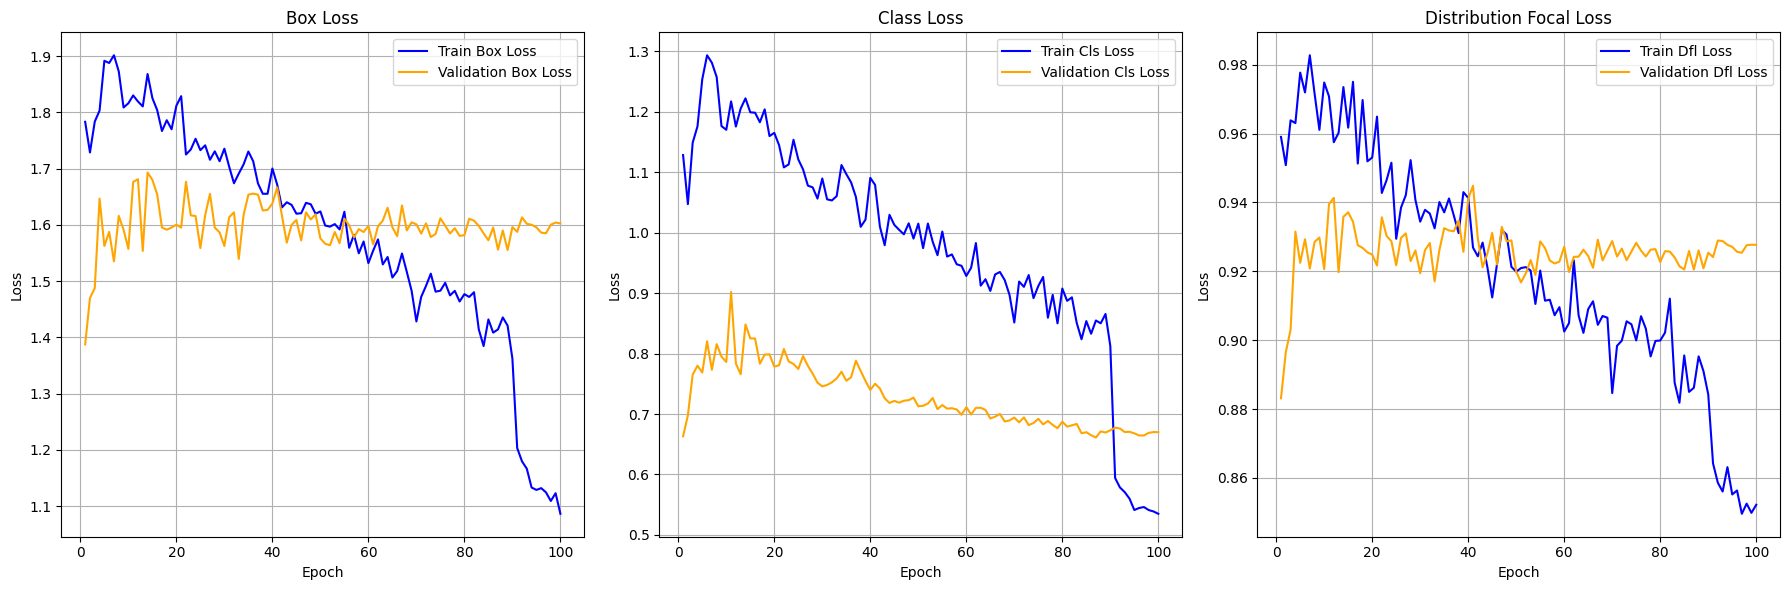

In [ ]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)



image 1/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_02.jpg: 640x640 3 missing_holes, 16.3ms
image 2/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_06.jpg: 640x640 3 missing_holes, 16.3ms
image 3/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_missing_hole_14.jpg: 640x640 3 missing_holes, 16.3ms
image 4/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_09.jpg: 640x640 (no detections), 16.3ms
image 5/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_14.jpg: 640x640 2 open_circuits, 16.4ms
image 6/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_open_circuit_18.jpg: 640x640 2 open_circuits, 16.5ms
image 7/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_short_14.jpg: 640x640 3 shorts, 16.3ms
image 8/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_short_15.jpg: 640x640 3 shorts, 16.3ms
image 9/34 /content/drive/MyDrive/PCB_DATASET/output/images/val/01_

In [ ]:
predict_dir = '/content/runs/detect/predict'
dest_predict_dir = os.path.join(root_dir, 'results/predict')

shutil.copytree(predict_dir, dest_predict_dir)

FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/results/predict'

In [ ]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [ ]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(dest_predict_dir, 'labels/05_missing_hole_05.txt')
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[0.0, 0.583211, 0.541547, 0.0221218, 0.0236916, 0.853473],
 [0.0, 0.596088, 0.84473, 0.018931, 0.0239948, 0.826977],
 [0.0, 0.872605, 0.748222, 0.0204969, 0.0252983, 0.808534],
 [0.0, 0.810697, 0.887343, 0.0253254, 0.0271946, 0.80104],
 [0.0, 0.731804, 0.60018, 0.0211015, 0.0261727, 0.789225],
 [5.0, 0.625419, 0.757248, 0.0395029, 0.0211498, 0.286849]]

In [ ]:
pred_annot_df = yolo_to_original_annot('05_missing_hole_05.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

filename  width  height         class  xmin  ymin  xmax  \
0  05_missing_hole_05.jpg   2544    2156  missing_hole  1455  1142  1511   
1  05_missing_hole_05.jpg   2544    2156  missing_hole  1492  1795  1540   
2  05_missing_hole_05.jpg   2544    2156  missing_hole  2193  1585  2245   
3  05_missing_hole_05.jpg   2544    2156  missing_hole  2030  1883  2094   
4  05_missing_hole_05.jpg   2544    2156  missing_hole  1834  1265  1888   

   ymax  confidence  
0  1193    0.853473  
1  1847    0.826977  
2  1640    0.808534  
3  1942    0.801040  
4  1322    0.789225

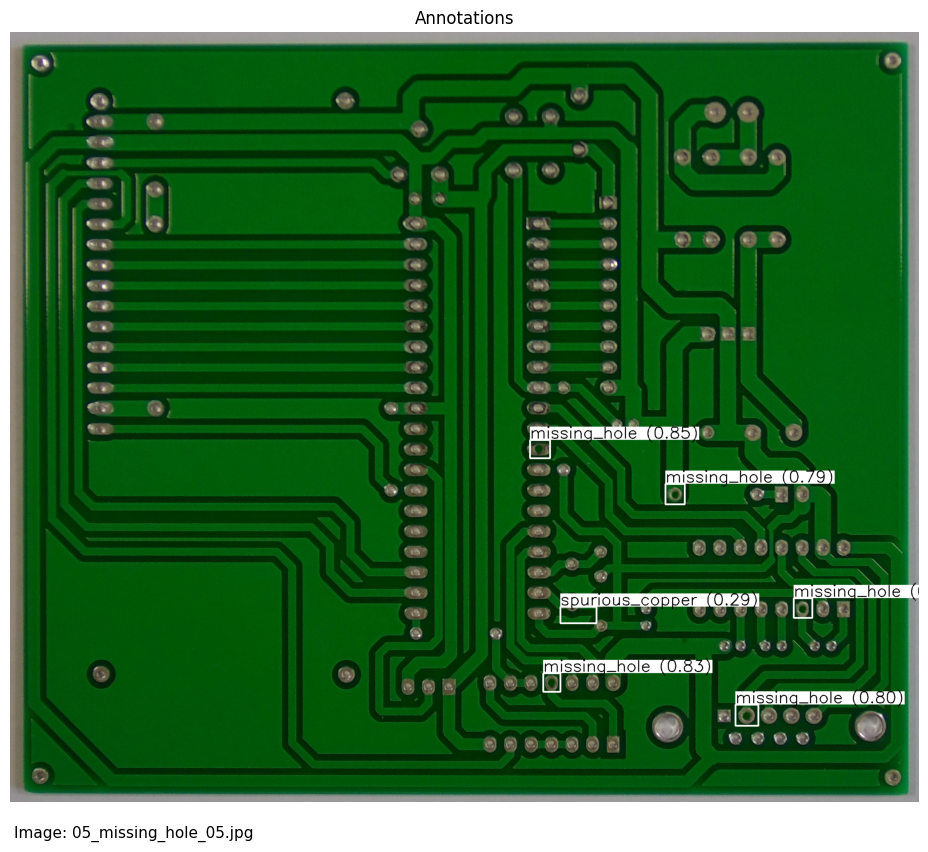

In [ ]:
visualize_annotations('05_missing_hole_05.jpg', images_dir, pred_annot_df, is_subfolder=True);


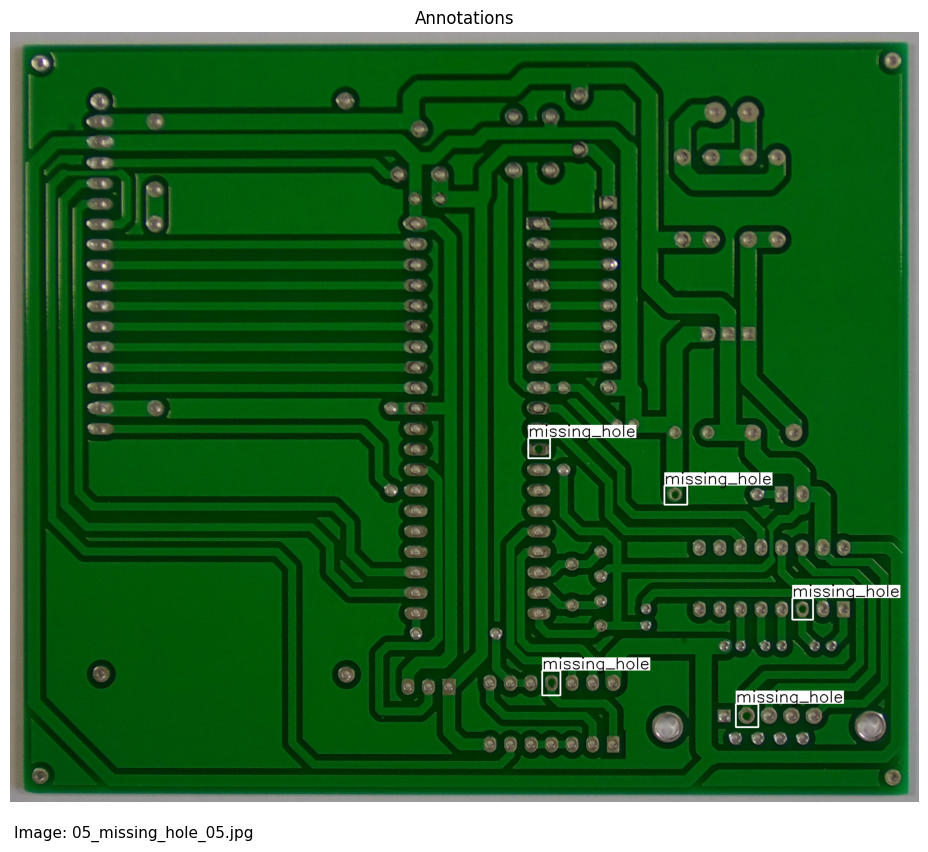

In [ ]:
visualize_annotations('05_missing_hole_05.jpg', images_dir, annot_df, is_subfolder=True);

In [ ]:
model.export()

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from '/content/drive/MyDrive/results/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)

TorchScript: starting export with torch 2.5.1+cu121...
TorchScript: export success ✅ 4.0s, saved as '/content/drive/MyDrive/results/weights/best.torchscript' (42.9 MB)

Export complete (6.8s)
Results saved to /content/drive/MyDrive/results/weights
Predict:         yolo predict task=detect model=/content/drive/MyDrive/results/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/content/drive/MyDrive/results/weights/best.torchscript imgsz=640 data=/content/drive/MyDrive/PCB_DATASET/output/3fold_crossval/split_3/split_3_dataset.yaml  
Visualize:       https://netron.app


'/content/drive/MyDrive/results/weights/best.torchscript'

In [ ]:
custom_img_dir = os.path.join(root_dir, 'custom_images')
resized_custom_img_dir = os.path.join(custom_img_dir, 'resized')
resize_images(custom_img_dir, resized_custom_img_dir) # Resize the images to 640x640

In [ ]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

image_path = os.path.join(resized_custom_img_dir, 'pcb_mouse_bite.jpg')
result_custom = model(image_path, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/1 /content/drive/MyDrive/custom_images/resized/pcb_mouse_bite.jpg: 640x640 5 mouse_bites, 16.2ms
Speed: 2.0ms preprocess, 16.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict11
1 label saved to runs/detect/predict11/labels


In [ ]:
predict_dir = '/content/runs/detect/predict11'
dest_custom_predict_dir = os.path.join(custom_img_dir, 'results/predict_11')

shutil.copytree(predict_dir, dest_custom_predict_dir)

'/content/drive/MyDrive/custom_images/results/predict_11'